# Tarea 2 - Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Usando el ejemplo de covid-19 en el notebook de feature-eng (https://colab.research.google.com/drive/1sJV2HG7tQgCGKES3-dIclzHQJ9qAWB3b?usp=sharing) crear un modelo de covid-19 para Guatemala.

* Convertir la fecha a un entero "número de día", por ejemplo si se usan datos desde el 22 de abril, este es el día 0, el 23 es el día 1.
* Aplicar regresión lineal sobre la variable "Confirmed" transformada.
* Una vez entrenado el modelo usarlo para aproximar la cantidad de casos confirmados para el 6 de Junio. Se debe reportar la cantidad de casos, no la cantidad transformada obtenida.

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

Instructions for updating:
non-resource variables are not supported in the long term


Filtraremos los datos para Guatemala, ya que son los que nos interesan y cambiaremos el tipo de dato de "Date" que es un string a date

In [4]:
covid = pd.read_csv("covid_19_clean_complete.csv")

covidGt = covid[(covid["Country/Region"] == "Guatemala") & (covid["Confirmed"] > 0)].copy()
covidGt["Date"] = pd.to_datetime(covidGt["Date"], infer_datetime_format = True)

Graficamos los datos para tener una idea de como se comportan los datos de interes

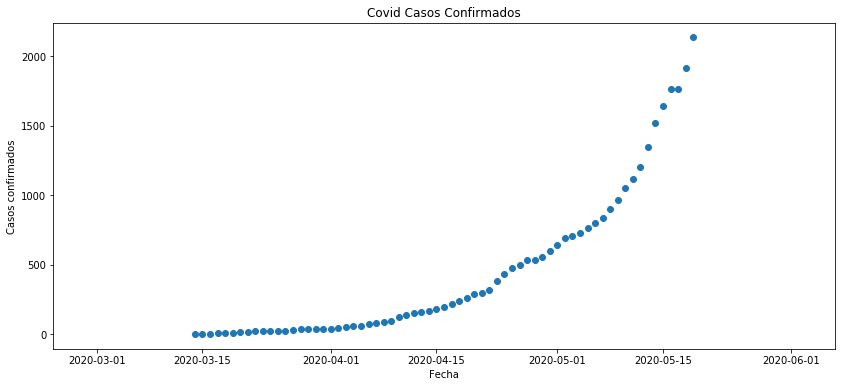

In [6]:
plt.figure(figsize = (14, 6))
plt.scatter(x = covidGt["Date"], y = covidGt["Confirmed"])

plt.title("Covid Casos Confirmados")
plt.xlabel("Fecha")
plt.ylabel("Casos confirmados")
plt.show()

Transformamos los datos de confirmed usando el logaritmo natural.

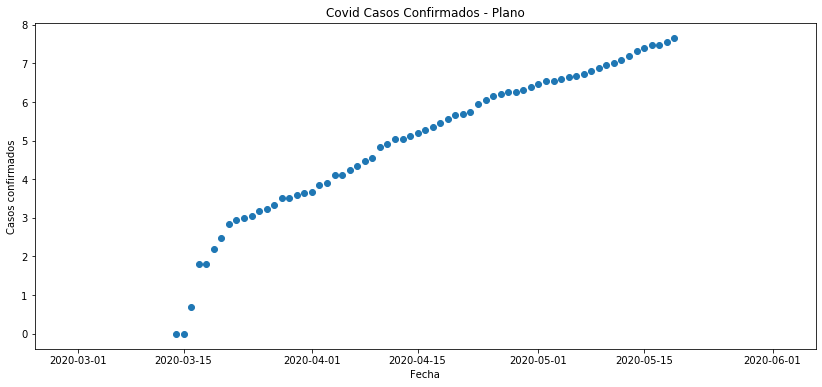

In [7]:
covidGt["ln_confirmed"] = np.log(covidGt["Confirmed"])

plt.figure(figsize = (14, 6))
plt.scatter(x = covidGt["Date"], y = covidGt["ln_confirmed"])
plt.title("Covid Casos Confirmados - Plano")
plt.xlabel("Fecha")
plt.ylabel("Casos confirmados")
plt.show()

Los primeros 7 elementos de la data parecen no ayudar al módelo, todos estos pertenecen a un ln(confirmed) < 2.5, así que eliminaremos a estos.
También transformamos la fecha, en vez de usar la fecha usaremos el número de día.

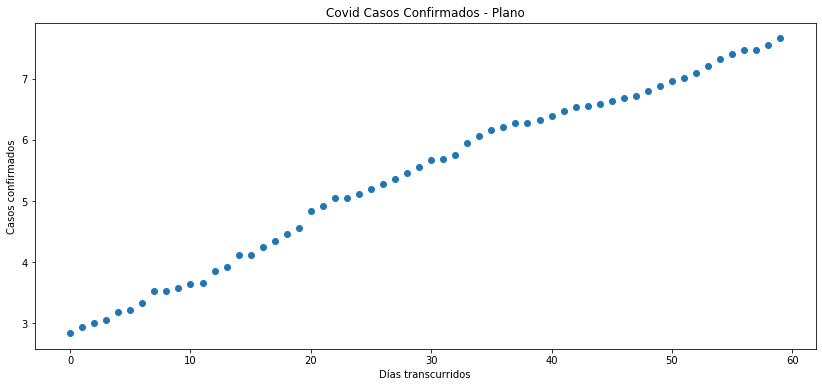

In [8]:
covidGt = covidGt[(covidGt["ln_confirmed"] > 2.5)].copy()
covidGt["day"] = np.arange(len(covidGt))

plt.figure(figsize = (14, 6))
plt.scatter(x = covidGt["day"], y = covidGt["ln_confirmed"])
plt.title("Covid Casos Confirmados - Plano")
plt.xlabel("Días transcurridos")
plt.ylabel("Casos confirmados")
plt.show()

Creación del módelo gradient descent, igual al del laboratorio pasado.

In [9]:
def gradient_descent(x, y, epochs, lr, print_rate=100):
    tf.reset_default_graph()
    
    with tf.name_scope("input"):
        x = tf.concat([x, tf.ones_like(x)], axis = 1)
    with tf.name_scope("params"):
        params = tf.Variable(name="params", initial_value = tf.zeros((2, 1), tf.float64))
    with tf.name_scope("predict"):
        y_hat = tf.matmul(x, params)
    with tf.name_scope("error"):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
    with tf.name_scope("gradient"):
        gradients = tf.gradients(error, params)
    with tf.name_scope("update_model"):
        fit = tf.scalar_mul(-lr, gradients[0])
        update_model = tf.assign(params, tf.add(params, fit))


    with tf.Session() as session:
        summary = tf.summary.scalar(name = "error_epochs", tensor = error)
        writer = tf.summary.FileWriter("./logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_epochs=" + str(epochs), session.graph)
        session.run(tf.global_variables_initializer())
        for epoch in range(0, epochs):
            if ((epoch + 1) % print_rate) == 0:
                print("error: " + str(session.run(error)))
      
            writer.add_summary(session.run(summary), epoch)
            session.run(update_model)

        params = session.run(params)

        writer.close()
    session.close()

    return params[0][0], params[1][0]


In [10]:
x = np.array(covidGt["day"], dtype = float).reshape(-1, 1)
y = np.array(covidGt["ln_confirmed"]).reshape(-1, 1)

In [11]:
epochs = 15000
m, b = gradient_descent(x, y, 15000, 0.0017, epochs / 5)

error: 0.095408125391662
error: 0.018585920991864822
error: 0.012954848982381894
error: 0.01254209107958907
error: 0.012511835901528627


Con un learning rate mayor a 0.0017 el módelo diverge, y con un learning rate mayor el módelo se tarda más en converger. 
Después de las 15,000 iteraciones no parece haber mucho cambio en el error.

In [12]:
print("pendiente = " + str(m))
print("intercepto = " + str(b))

pendiente = 0.08275469701349958
intercepto = 2.9690684556021965


In [13]:
day = (datetime.datetime.strptime("2020-06-06","%Y-%m-%d") - covidGt.iloc[0]["Date"]).days
y_hat = np.exp(m * day + b)
print(y_hat)

11397.851202893358


Con esto podemos decir que esperamos una cantidad de 11398 casos para el 6 de junio (77 días después).

### Parte 2 - Modelo polinomial de calidad de vinos

Es permitido utilizar [sklearn.preprocessing.polynomialfeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [15]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [16]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


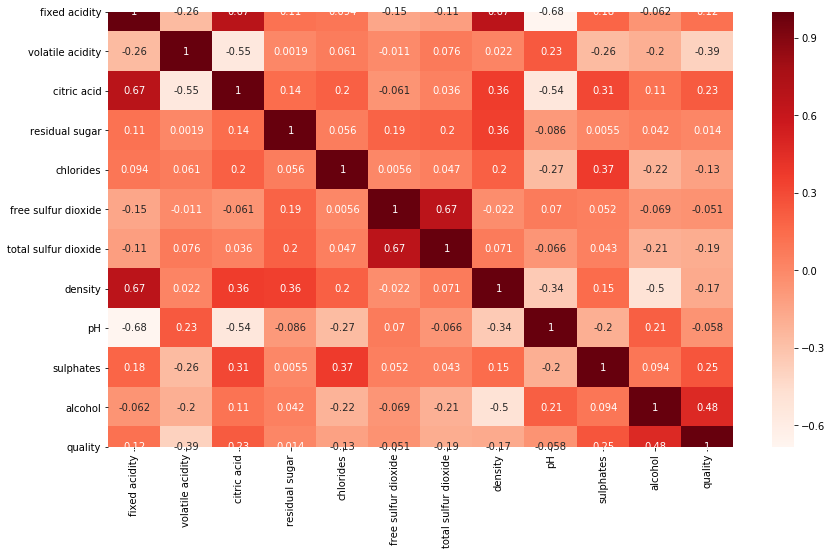

In [17]:
corr = data.corrwith(data["quality"])

plt.figure(figsize=(14, 8))
sns.heatmap(data.corr(), cmap="Reds", annot=True)

Con esto podemos identificar dos variables, alcohol y volatile acidity, aunque ninguna de las dos parece muy alta son las más altas. Hay que tener en cuenta que volatile acidity es negativo, esto podría indicar que entre este es menor la calidad es mayor.

In [18]:
volatileAcidity = data[["volatile acidity"]].to_numpy()
alcohol = data[["alcohol"]].to_numpy()

x = np.hstack((alcohol, volatileAcidity))
y = data[["quality"]].to_numpy()

Al parecer nuestro módelo anterior necesita unos cambios para funcionar en este problema, en vez de cambiarlo haré uno nuevo así no necesito hacer cambios en el ejercicio de covid-19 y tengo una copia de como lo hice antes en caso el nuevo sea muy diferente

In [19]:
def gradientDescent(x, y, epochs, lr, degree, modelName, printRate):
    tf.reset_default_graph()

    with tf.name_scope("params"):
        params = tf.Variable(name="params", initial_value = tf.zeros((x.shape[1], 1), tf.float64))
    with tf.name_scope("predict"):
        y_hat = tf.matmul(x, params)
    with tf.name_scope("error"):
        error = 1/2 * tf.reduce_mean(tf.math.square(y - y_hat))
    with tf.name_scope("gradient"):
        gradients = tf.gradients(error, params)
    with tf.name_scope("update_model"):
        fit = tf.scalar_mul(-lr, gradients[0])
        update_model = tf.assign(params, tf.add(params, fit))


    with tf.Session() as session:
        summary = tf.summary.scalar(name = "error_epochs", tensor = error)
        writer = tf.summary.FileWriter("./" + modelName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_lr=" + str(lr) + "_degree=" + str(grade), session.graph)
        session.run(tf.global_variables_initializer())
        for epoch in range(0, epochs):
            if ((epoch + 1) % printRate) == 0:
                print("error: " + str(session.run(error)))
      
            writer.add_summary(session.run(summary), epoch)
            session.run(update_model)

        params = session.run(params)

        writer.close()
    session.close()

    return params


![text](graphs/wine-model.png)

In [42]:
def transformInput(x, degree, scaled = False):
    if (scaled):
        scaler = MinMaxScaler()
        x = scaler.fit_transform(x).copy()

    poly = PolynomialFeatures(degree = degree)
    return poly.fit_transform(x)

In [64]:
def wineGradientDescent(x, y, epochs, lr, degree):
    printRate = epochs / 5
    return gradientDescent(x, y, epochs, lr, degree, "wine", printRate)

In [69]:
coeficientsX2 = wineGradientDescent(transformInput(x, 2), y, 100000, 0.00015, 2)

error: 0.22307053962696458
error: 0.2218970062584871
error: 0.22189016158305466
error: 0.2218878416366294
error: 0.2218855834770287


In [68]:
coeficientsX2S = wineGradientDescent(transformInput(x, 2, True), y, 4000, 0.9, 2)

error: 0.22245520044054884
error: 0.22207043851209188
error: 0.22190570681482732
error: 0.2218286110589964
error: 0.221788777750184


Para el polinomio de grado dos encontré hice varias pruebas y las separe en dos.
El trazo de color rojo es con las variables x sin normalizar, el cual encontré que el valor más grande que no hace diverger el error era con un learning rate de 0.00015.
El trazo de color azul es con las variables x normalizadas, y encontré que con 0.9 seguía siendo un valor con el cual el error no diverge, pero podría aún encontrar un valor más grande que este.
Al principio con las variables sin normalizar hice 10,000 iteraciones y después de eso parecía que el módelo ya no cambiaba mucho, pero al hacer las pruebas con las variables escaladas me di cuenta que llegaba a un error menos haciendo mucho menos iteraciones. Por esa razón empecé a poner más iteraciones al módelo con las variables sin normalizar.
En la gráfica se puede observar que con el módelo con el input normalizado seguimos teniendo menor error haciendo 4,000 iteraciones que sin normalizar haciendo 100,000 iteraciones.
Por lo tanto tomaríamos el módelo de grado dos con el input normalizado como el mejor módelo, o mejor dicho, el módelo es más rápido y eficiente en este casi si normalizamos el input primero.
Se puede observar también que el módelo sin normalizar no cambia mucho después de las 30,000 iteraciones aproximadamente. 

![text](graphs/degree2.png)

In [95]:
coeficientsX3 = wineGradientDescent(transformInput(x, 3), y, 100000, 0.0000013, 3)

error: 0.22791318960123416
error: 0.2254476515808213
error: 0.22542817119543437
error: 0.22541643599482925
error: 0.22540489279658868


In [97]:
coeficientsX3S = wineGradientDescent(transformInput(x, 3, True), y, 4000, 0.9, 3)

error: 0.2217084681158516
error: 0.22134868303760388
error: 0.22121720704976647
error: 0.22111719660869789
error: 0.22102604784818108


Para el polinomio de grado 3 se ve que con el input sin normalizar resulta en el peor módelo, y además el más lento. Aunque lo lento se puede ver que tiene que ver con que el learning rate más grande que no hacía diverger el error es de 0.0000013, tal vez usando aún más iteraciones podríamos llegar a tener el mismo error que el de grado 2 sin normalizar, pero creo que no es necesario hacer esa prueba y es fácil descartar este módelo.
Por el otro lado, el módelo de grado 3 con input normalizado usando las mismas iteraciones y learning rate que el módelo de grado 2 resultó en un error aún menor y ambos usan un tiempo de aproximandamente 0 segundos para entrenarse.
Entonces yo escogería el módelo de grado 3, tomando en cuenta que mi data no la separe en data de entrenamiento y testing, y por lo tanto no puedo saber si usando el módelo de grado 3 pueda existir overfiting.

![text](graphs/degree3.png)